# 1. <a id='toc1_'></a>[Import packages](#toc0_)

First, we import the necessary packages for this exercise.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature

%matplotlib inline

In [2]:
# Change to directory where data is stored
data_dir = "../data"  # "/kyukon/data/gent/courses/2024/computphys_C004504/input"

**Table of contents**<a id='toc0_'></a>    
- 1. [Import packages](#toc1_)    
- 2. [Open simulation data](#toc2_)    
  - 2.1. [Solutions:](#toc2_1_)    
- 3. [Investigate UHI](#toc3_)    
  - 3.1. [Solutions:](#toc3_1_)    
- 4. [Energy exchange with the surface](#toc4_)    
  - 4.1. [Solutions:](#toc4_1_)    
- 5. [Cold start vs. soil spin-up](#toc5_)    
  - 5.1. [Solutions:](#toc5_1_)    
- 6. [Extra 1. Locations with a heatwave](#toc6_)    
  - 6.1. [Solutions:](#toc6_1_)    
- 7. [Extra 2. Simulation without urban areas](#toc7_)    
  - 7.1. [Solutions:](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 2. <a id='toc2_'></a>[Open simulation data](#toc0_)

- Open the 2-meter temperature (variable `tas`) data for the `initSFX`-simulation starting at midnight on 1 July 2019 and running for 720 hours: `initSFX_2019070100_720_tas_2019-07-01T01_2019-07-31T00_3600_regridded.nc`
- Which units are used for the temperature? Convert these units to degrees Celsius (if necessary) for this exercise. This will facilitate the interpretation of results.
- Let's now focus on one location: the Royal Meteorological Institute of Belgium (RMI) in Uccle. Select the temperature data for this location from the simulation dataset. Do so by finding the point in the simulation grid, which lies closest to the RMI. The coordinates of the RMI are 50.799 N, 4.359 E.
- From 22 until 26 July 2019, we experienced a short, but very intense heat wave in Belgium. The RMI speaks of a heat wave when the maximum temperatures in Uccle reach at least 25 degrees for at least 5 consecutive days, with at least 30 degrees  being reached on at least three days (see [heat wave definition](https://www.meteo.be/nl/info/weerwoorden/hittegolf) in Dutch). Select this 5-day period from the data and verify if these conditions for a heat wave are met in the simulation data by inspecting a plot.

## 2.1. <a id='toc2_1_'></a>[Solutions:](#toc0_)

We will write a function for loading in the data and converting temperature variables to degrees Celsius.

In [3]:
def convert_to_Celsius(ds):
    for var_name in ["tas", "ts", "tsl1", "tsl2", "troad1"]:
        if var_name in ds:
            ds[var_name].values = ds[var_name].values - 273.15
            ds[var_name].attrs["units"] = "°C"

    return ds


def open_data(data_dir, var_name_list, run_name_list):
    ds_list_list = list()
    ds_land_use_list = list()

    for run_name in run_name_list:
        ds_list = list()

        for var_name in var_name_list:
            ds = xr.open_dataset(
                f"{data_dir}/{run_name}_2019070100_720_{var_name}_2019-07-01T01_2019-07-31T00_3600_regridded.nc",
                engine="netcdf4",
            )
            ds_list.append(ds)

        ds = xr.merge(ds_list, compat="minimal")
        ds_list_list.append(ds)

        # Open the corresponding land use data (see next exercise)
        ds_land_use = xr.open_dataset(
            f"{data_dir}/{run_name}_landuse_regridded.nc",
            engine="netcdf4",
            chunks="auto",
        )
        ds_land_use_list.append(ds_land_use)

    ds = xr.concat(ds_list_list, dim="run_name")
    ds_land_use = xr.concat(ds_land_use_list, dim="run_name")

    ds = xr.merge([ds, ds_land_use])
    ds = convert_to_Celsius(ds)

    return ds

In [4]:
var_name_list = ["tas"]
run_name_list = ["initSFX"]

ds = open_data(data_dir, var_name_list, run_name_list)
ds

<xarray.Dataset>
Dimensions:      (time: 720, lon: 75, lat: 70, run_name: 1, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
  * lon          (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.97 7.04 7.11 7.18
  * lat          (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds    (time, bnds) datetime64[ns] ...
    height       float64 ...
    crs          int64 ...
    rstart       <U10 ...
  * run_name     (run_name) <U7 'initSFX'
Dimensions without coordinates: bnds
Data variables:
    tas          (run_name, time, lat, lon) float32 16.69 17.13 ... 22.42 22.4
    frac_town    (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_water   (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_nature  (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_sea     (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:18:38Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [5]:
lat_rmi, lon_rmi = 50.799, 4.359
ds_rmi = ds.sel(lon=lon_rmi, lat=lat_rmi, method="nearest")
ds_rmi

<xarray.Dataset>
Dimensions:      (time: 720, run_name: 1, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
    lon          float64 4.38
    lat          float64 50.8
    time_bnds    (time, bnds) datetime64[ns] ...
    height       float64 ...
    crs          int64 ...
    rstart       <U10 ...
  * run_name     (run_name) <U7 'initSFX'
Dimensions without coordinates: bnds
Data variables:
    tas          (run_name, time) float32 16.88 16.61 16.42 ... 17.18 16.59
    frac_town    (run_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_water   (run_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_nature  (run_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_sea     (run_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:18:38Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

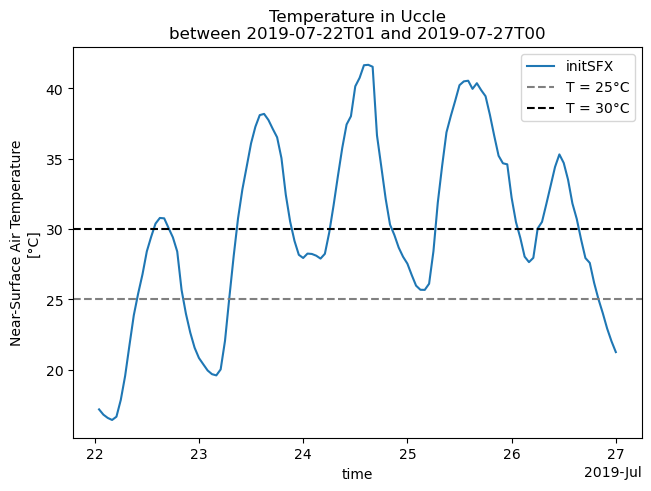

In [6]:
# Change this to period of heat wave
tstart = "2019-07-22T01"
tstop = "2019-07-27T00"
var_name = "tas"
run_name = "initSFX"
ds_rmi_period = ds_rmi.sel(time=slice(tstart, tstop), run_name=run_name)

### Temperatures

fig, ax = plt.subplots(figsize=(6.4, 4.8), layout="constrained")

var = ds_rmi_period[var_name]
long_name = var.attrs["long_name"]
var.plot(ax=ax, x="time", label=run_name)

ax.set_title(f"Temperature in Uccle\nbetween {tstart} and {tstop}")
ax.axhline(25, linestyle="--", color="grey", label="T = 25°C")
ax.axhline(30, linestyle="--", color="black", label="T = 30°C")
ax.legend()

plt.show()

This five-day period just qualifies as a heat wave.

# 3. <a id='toc3_'></a>[Investigate UHI](#toc0_)

In this next part of the practical, we will investigate the Urban Heat Island (UHI) in the simulations. We will do so by comparing the simulation to the MOCCA observational network. This network consists of 6 stations located in the city of Ghent. Each station is placed in a different urban environment, to gauge the influence of this environment on the micro-climate. One of these stations is located outside of the city, in Melle, and can be considered a rural station. We can define the UHI intensity by calculating the temperature difference between an urban and a rural station. This difference in temperature depends on the time of day. Therefore, the UHI is often studied by computing a so-called diurnal (or daily) cycle. This diurnal cycle is constructed by taking an average of the data over a certain period for each hour of the day. For example, all the data at midnight are averaged together, the data at 1:00, ... This diurnal cycle represents the variations throughout the day.

For this exercise, we will work with the `tas`-variable from the `initSFX`-simulation from 1 July 2019 (720 hours). We will also need the land use information stored in `initSFX_landuse_regridded.nc`.  

- Load in the MOCCA station data for the period of the heat wave. These data are stored in the file `MOCCA_tas_2019-07-22T01_2019-07-27T00.nc`. Explore the data.
- Load in the simulation data together with the land use information. Write a function called `open_data`, which takes the data directory, variable names and run names and loads in the corresponding variables and land use information as one dataset.
- Take a look at the land use data. How is this land use stored in the dataset?
- We will now consider these locations in the simulation data. Select the points in the simulation data which are closest to each of the stations. Assign coordinates so that you get an xarray DataSet with the same dimensions as the observations: `(time, locations)`
- For each of the locations, consider the town fraction. Select the locations with the lowest and highest town fraction from the stations. We will use these to represent rural and urban locations respectively.
- For the period of the heat wave (22-26 July 2019), calculate the diurnal cycle of temperature for both locations for the simulation data. Plot the difference between the urban and rural diurnal cycles. Is a urban heat island present in the simulations? What is the UHI intensity? At what hours of the day is it the highest?
- Repeat the previous step for the observational data. Compare this result with the simulation data.
- Where does the difference in UHI intensity between the simulation and observations come from? Plot the bias of the diurnal cycle in temperature for both locations. Link the difference in UHI between the simulation and observations to the bias at the urban and rural locations.

## 3.1. <a id='toc3_1_'></a>[Solutions:](#toc0_)

In [7]:
tstart = "2019-07-22T01"
tstop = "2019-07-27T00"
obs = xr.open_dataset(f"{data_dir}/MOCCA_tas_{tstart}_{tstop}.nc", engine="netcdf4")
obs

<xarray.Dataset>
Dimensions:   (time: 120, location: 6)
Coordinates:
    index     (time) int64 ...
    year      (time) int64 ...
    month     (time) int64 ...
    day       (time) int64 ...
    hour      (time) int64 ...
  * time      (time) datetime64[ns] 2019-07-22T01:00:00 ... 2019-07-27
    lon       (location) float64 ...
    lat       (location) float64 ...
  * location  (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
Data variables:
    tas       (location, time) float64 ...

In [8]:
var_name_list = ["tas"]
run_name_list = ["initSFX"]
ds = open_data(data_dir, var_name_list, run_name_list)
ds

<xarray.Dataset>
Dimensions:      (time: 720, lon: 75, lat: 70, run_name: 1, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
  * lon          (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.97 7.04 7.11 7.18
  * lat          (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds    (time, bnds) datetime64[ns] ...
    height       float64 ...
    crs          int64 ...
    rstart       <U10 ...
  * run_name     (run_name) <U7 'initSFX'
Dimensions without coordinates: bnds
Data variables:
    tas          (run_name, time, lat, lon) float32 16.69 17.13 ... 22.42 22.4
    frac_town    (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_water   (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_nature  (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_sea     (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:18:38Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

The land use data is stored as fractions in the variables: frac_town, frac_water, frac_nature and frac_sea.

In [9]:
ds_locations_list = list()

for location in obs.location:
    lat = obs.lat.sel(location=location).values
    lon = obs.lon.sel(location=location).values
    ds_location = ds.sel(lat=lat, lon=lon, method="nearest").sel(run_name="initSFX")
    ds_locations_list.append(ds_location.assign_coords(location=location.values))

ds_locations = xr.concat(ds_locations_list, dim="location")
ds_locations

<xarray.Dataset>
Dimensions:      (time: 720, location: 6, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
    lon          (location) float64 3.75 3.82 3.75 3.68 3.75 3.75
    lat          (location) float64 51.07 50.98 51.12 51.07 51.02 51.07
    time_bnds    (time, bnds) datetime64[ns] 2019-07-01 ... 2019-07-31
    height       float64 2.0
    crs          int64 0
    rstart       <U10 '2019070100'
    run_name     <U7 'initSFX'
  * location     (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
Dimensions without coordinates: bnds
Data variables:
    tas          (location, time) float32 16.67 16.74 16.79 ... 17.89 17.6 17.24
    frac_town    (location) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_water   (location) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_nature  (location) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frac_sea     (location) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:18:38Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [10]:
ds_locations.frac_town.load()

<xarray.DataArray 'frac_town' (location: 6)>
array([0.48960358, 0.0720843 , 0.20285054, 0.41070563, 0.41838965,
       0.48960358], dtype=float32)
Coordinates:
    lon       (location) float64 3.75 3.82 3.75 3.68 3.75 3.75
    lat       (location) float64 51.07 50.98 51.12 51.07 51.02 51.07
    height    float64 2.0
    crs       int64 0
    rstart    <U10 '2019070100'
    run_name  <U7 'initSFX'
  * location  (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
Attributes:
    standard_name:  town_fraction
    long_name:      Town Fraction
    units:          %

Provinciehuis (and Sint-Bavo) have the highest town fraction (49 %); Melle has the lowest (7 %).

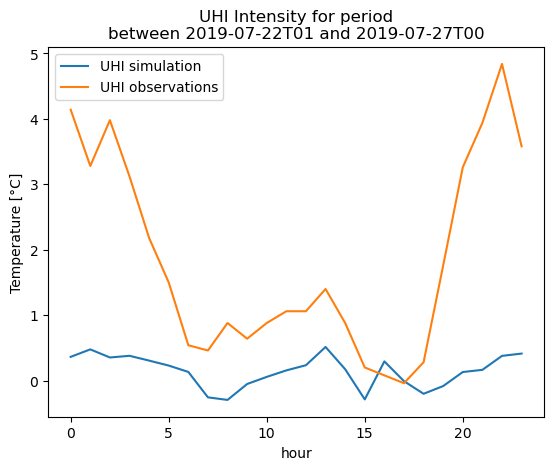

In [11]:
fig, ax = plt.subplots()

ds_uhi = ds_locations.sel(location="Provinciehuis") - ds_locations.sel(location="Melle")
ds_uhi_period = ds_uhi.sel(time=slice(tstart, tstop))
tas_uhi_dc = ds_uhi_period.groupby("time.hour").mean().tas
tas_uhi_dc.plot(ax=ax, label="UHI simulation")

obs_uhi = obs.sel(location="Provinciehuis") - obs.sel(location="Melle")
obs_tas_uhi_dc = obs_uhi.groupby("time.hour").mean().tas
obs_tas_uhi_dc.plot(ax=ax, label="UHI observations")

ax.set_title(f"UHI Intensity for period\nbetween {tstart} and {tstop}")
ax.set_ylabel("Temperature [°C]")
ax.legend()

plt.show()

An nightly UHI is present in the simulations but it is quite small, with a magnitude of only 0.5°C. On the other hand, the observations exhibit a very clear and strong UHI with a magnitude of up to 4°C.

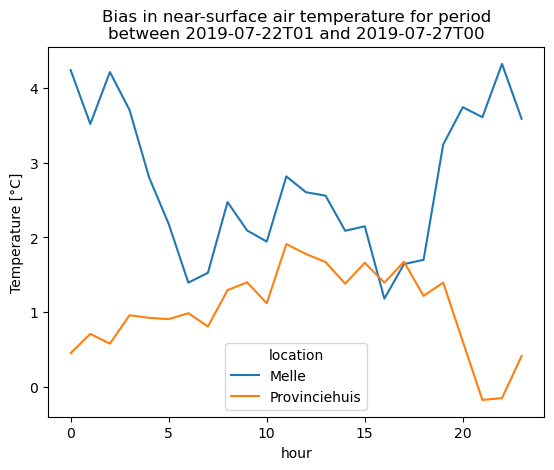

In [12]:
bias = (ds_locations - obs).sel(location=["Melle", "Provinciehuis"])
bias_tas_dc = bias.groupby("time.hour").mean().tas

fig, ax = plt.subplots()
bias_tas_dc.plot(ax=ax, hue="location")
ax.set_title(
    f"Bias in near-surface air temperature for period\nbetween {tstart} and {tstop}"
)
ax.set_ylabel("Temperature [°C]")

plt.show()

Plotting the bias in both locations shows that the simulations are too warm compared to the observations. However, at nighttime in Melle, the warm bias is more than 3 degrees higher in Melle, which explains why the UHI is much less present in the simulations.

If we take $T^S_U$ and $T^S_R$ as the simulated temperatures for respectively an urban and rural location, and $T^O_U$ and $T^O_R$ for the observational values, we can connect the UHI values with the biases as follows:
$$UHI^S = T^S_U - T^S_R \text{ and } UHI^O = T^O_U - T^O_R$$
$$BIAS_R = T^S_R - T^O_R \text{ and } BIAS_U = T^S_U - T^O_U$$
$$\Longrightarrow BIAS_U - BIAS_R = UHI^S - UHI^O$$

# 4. <a id='toc4_'></a>[Energy exchange with the surface](#toc0_)

An important factor which influences the state of the atmosphere, and hence the weather, is its interaction with the surface. This interaction can be represented as the exchange of energy in the form of fluxes. We consider three types of energy exchange: radiation, sensible heat flux and latent heat flux. The variable names corresponding to these fluxes are respectively `rnetds`, `hfss` and `hfls`.

- Load in the simulation data of these fluxes for the `initSFX`-simulation from 1 July 2019 (720 hours).
- What are the units of these fluxes?
- Select again the data from Uccle and from the period between 22 and 26 July 2019. Plot the ernergy fluxes in function of time. 
- We will now determine the sign of these fluxes:
    - The radiation flux `rnetds` is the net radiation flux: it is the difference between the incoming and outgoing radiation. The incoming radiation is primarily shortwave radiation: either direct (from the Sun) or diffuse (scattered solar radiation). The outgoing radiation is emmited by the surface itself; it is longwave radiation. The difference between these two contributions is the net radiation flux. When is this variable positive and negative? What does this mean: is a positive flux directed into or out of the surface?
    - The sensible heat flux `hfss` is the heat transfer caused by the temperature difference between the surface and the atmosphere. The heat is transfered from the medium with the highest temperature to the medium with the lowest temperature. Compare the near-surface air temperature (`tas`) with the surface temperature (`ts`). Use this difference between `ts` and `ts` to derive the sign of the sensible heat flux.
    - The latent heat flux is caused by the evaporation of soil moisture. This evaporation requires latent heat for the phase transition between the liquid and vapor phase. This heat is extracted from the soil, which causes it to cool. Consider the latent heat flux. In what direction is the postive latent heat flux defined? 
- Calculate the net energy flux into the surface by adding or subtracting (depending on how the direction is defined) the three flux contributions. Compare this with the surface temperature, stored in the variable `ts`.

## 4.1. <a id='toc4_1_'></a>[Solutions:](#toc0_)

In [13]:
var_name_list = ["rnetds", "hfss", "hfls", "tas", "ts"]
run_name_list = ["initSFX"]
ds = open_data(data_dir, var_name_list, run_name_list)
ds

<xarray.Dataset>
Dimensions:      (time: 720, lon: 75, lat: 70, run_name: 1, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
  * lon          (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.97 7.04 7.11 7.18
  * lat          (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds    (time, bnds) datetime64[ns] 2019-07-01 ... 2019-07-31
    crs          int64 0
    rstart       <U10 '2019070100'
  * run_name     (run_name) <U7 'initSFX'
Dimensions without coordinates: bnds
Data variables:
    rnetds       (run_name, time, lat, lon) float32 -54.07 -55.14 ... -67.98
    hfss         (run_name, time, lat, lon) float32 2.34 7.096 ... -28.26 -28.61
    hfls         (run_name, time, lat, lon) float32 1.587 1.883 ... 0.6988
    tas          (run_name, time, lat, lon) float32 16.69 17.13 ... 22.42 22.4
    ts           (run_name, time, lat, lon) float32 16.91 17.49 ... 21.82 21.75
    frac_town    (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_water   (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_nature  (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_sea     (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:19:39Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

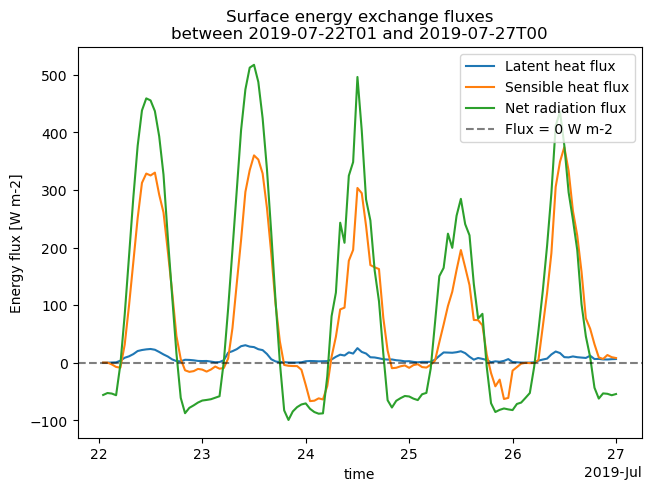

In [14]:
lat_rmi, lon_rmi = 50.799, 4.359
ds_rmi = ds.sel(lon=lon_rmi, lat=lat_rmi, method="nearest")

tstart = "2019-07-22T01"
tstop = "2019-07-27T00"
run_name = "initSFX"
ds_rmi_period = ds_rmi.sel(time=slice(tstart, tstop), run_name=run_name)

fig, ax = plt.subplots(layout="constrained")

ds_rmi_period.hfls.plot(ax=ax, x="time", label="Latent heat flux")
ds_rmi_period.hfss.plot(ax=ax, x="time", label="Sensible heat flux")
ds_rmi_period.rnetds.plot(ax=ax, x="time", label="Net radiation flux")

ax.set_title(f"Surface energy exchange fluxes\nbetween {tstart} and {tstop}")
ax.set_ylabel("Energy flux [W m-2]")

ax.axhline(linestyle="--", color="k", alpha=0.5, label="Flux = 0 W m-2")
ax.legend()

The net radiation flux is positive by day and negative by night. During daytime the net radiation flux is dominated by incoming solar radiation. This means that a positive sign for this flux denotes an energy flux going into the surface.

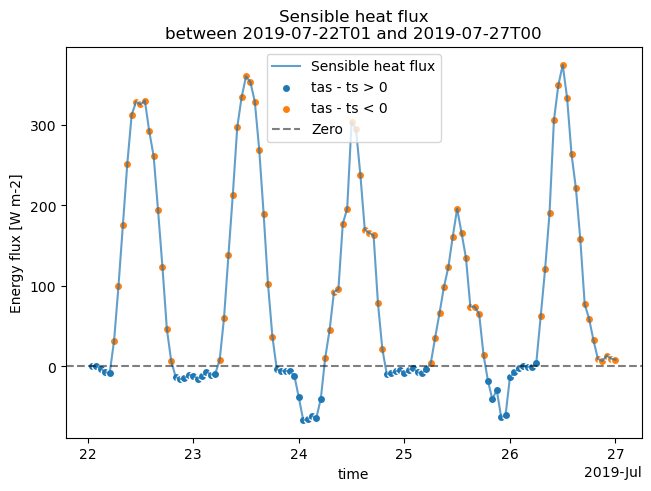

In [15]:
fig, ax = plt.subplots(layout="constrained")

hfss = ds_rmi_period.hfss
temp_diff = ds_rmi_period.tas - ds_rmi_period.ts

hfss.plot(ax=ax, x="time", label="Sensible heat flux", alpha=0.7)
hfss.where(temp_diff > 0).plot.scatter(ax=ax, x="time", label="tas - ts > 0")
hfss.where(temp_diff < 0).plot.scatter(ax=ax, x="time", label="tas - ts < 0")

ax.set_title(f"Sensible heat flux\nbetween {tstart} and {tstop}")
ax.set_ylabel("Energy flux [W m-2]")

ax.axhline(linestyle="--", color="k", alpha=0.5, label="Zero")
ax.legend()

plt.show()

The sensible heat flux is postive when the air temperature is smaller than the surface temperature. In that case the sensible heat flux is directed out of the surface, as it follows the direction from the warmer medium to the colder. Therefore, we can conclude that a postive sensible heat flux is defined as a flux going out of the soil.

The latent heat flux is positive by day and (almost) zero by night. During the day the evaporation of soil moisture is highest. Therefore, it follows that a positive latent heat flux is defined as going out of the surface. The latent heat flux never becomes negative.

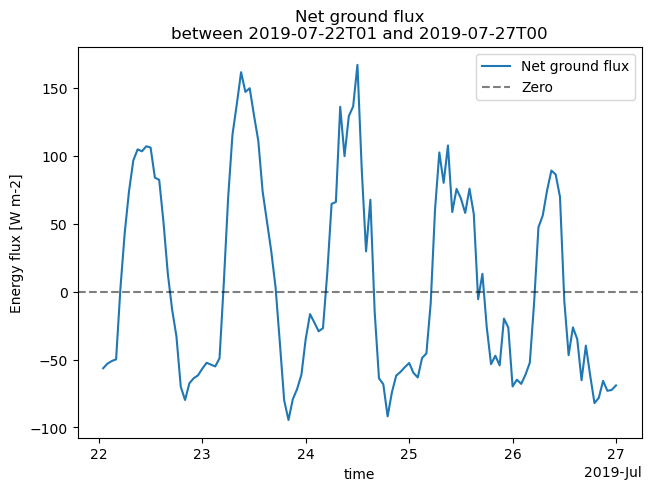

In [16]:
fig, ax = plt.subplots(layout="constrained")

netflux = ds_rmi_period.rnetds - ds_rmi_period.hfss - ds_rmi_period.hfls
netflux.plot(ax=ax, x="time", label="Net ground flux")

ax.set_title(f"Net ground flux\nbetween {tstart} and {tstop}")
ax.set_ylabel("Energy flux [W m-2]")

ax.axhline(linestyle="--", color="k", alpha=0.5, label="Zero")
ax.legend()

plt.show()

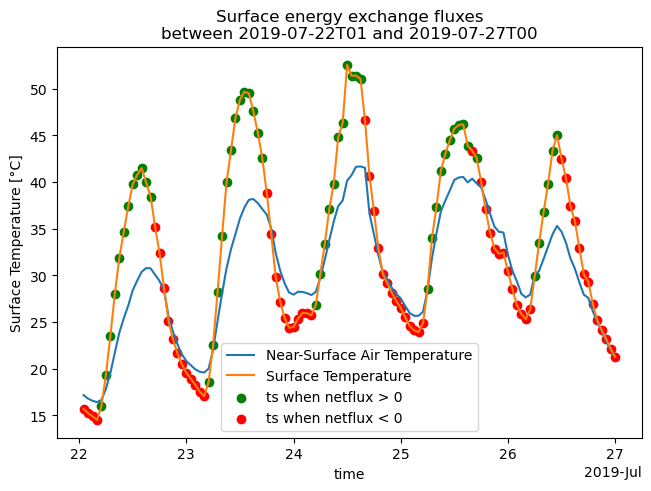

In [17]:
fig, ax = plt.subplots(layout="constrained")

tas = ds_rmi_period.tas
ts = ds_rmi_period.ts

tas.plot(label="Near-Surface Air Temperature")
ts.plot(label="Surface Temperature")
ts.where(netflux > 0).plot.scatter(color="green", label="ts when netflux > 0")
ts.where(netflux < 0).plot.scatter(color="red", label="ts when netflux < 0")

ax.set_title(f"Surface energy exchange fluxes\nbetween {tstart} and {tstop}")

ax.legend()

For the most part, the soil heats up when the net energy flux is positive, and it cools down when it is negative. However, this is not fully valid. The temperature already peaks before the flux changes sign. This can be explained by the presence of a second flux, going from the upper layer of the soil into the deeper layer.

# 5. <a id='toc5_'></a>[Cold start vs. soil spin-up](#toc0_)

In this practical, we have discussed the interaction between the surface and the atmosphere through fluxes. The simulation we discussed previously, `initSFX`, has been run with an initial surface state that was taken from a long-term climate simulation. This allows the soil variables to start from a state that was in equilibrium with the atmospheric variables. As these soil variables (such as temperature and moisture) are slowly-evolving, particularly the deep soil variables, the time to reach this equilibrium in a simulation can be of the order of months.

On the other hand, we have also run a simulation with a default initial surface state (we call this a cold start). This simulation is the `baseline`-simulation (also used in the practical about the Vesder case). For this simulation, the soil moisture and temperature variables are not yet in an equilibrium state and will hence first evolve towards this state. This will impact the atmospheric variables close to the surface. The process where a model moves towards an equilibrium state is called the spin-up period.

Investigate this by following these steps:
- Load in the following variables for the `baseline`- and `initSFX`-simulations for the simulations starting on 1 July 2019 (720 hours):
    - `tas`: near-surface air temperature
    - `hfss`, `hfls`, `rnetds`: surface energy fluxes
    - `ts`: surface temperature
    - `mrso`: total soil moisture
    - `tsl2`: deep soil temperature
- Select the data at the locations of the MOCCA stations for the heatwave period (22-26 July 2019). Plot the temperature for both simulations and compare to the observations. Which simulation performs best?
- Plot the average over the simulation domain of all variables. How can you see the behaviour of moving to equilibrium from these plots? Can you explain the differences between these two simulations? Think about how these variables influence each other and explain how these differences are connected.

## 5.1. <a id='toc5_1_'></a>[Solutions:](#toc0_)

In [18]:
var_name_list = ["hfls", "hfss", "rnetds", "tas", "ts", "mrso", "tsl2"]
run_name_list = ["baseline", "initSFX"]
ds = open_data(data_dir, var_name_list, run_name_list)
ds

<xarray.Dataset>
Dimensions:      (time: 720, lon: 75, lat: 70, run_name: 2, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
  * lon          (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.97 7.04 7.11 7.18
  * lat          (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds    (time, bnds) datetime64[ns] 2019-07-01 ... 2019-07-31
    crs          int64 0
    rstart       <U10 '2019070100'
  * run_name     (run_name) <U8 'baseline' 'initSFX'
Dimensions without coordinates: bnds
Data variables:
    hfls         (run_name, time, lat, lon) float32 17.88 16.41 ... 0.6988
    hfss         (run_name, time, lat, lon) float32 -25.09 -20.85 ... -28.61
    rnetds       (run_name, time, lat, lon) float32 -46.82 -45.89 ... -67.98
    tas          (run_name, time, lat, lon) float32 16.06 16.37 ... 22.42 22.4
    ts           (run_name, time, lat, lon) float32 15.32 15.45 ... 21.82 21.75
    mrso         (run_name, time, lat, lon) float32 1.372 1.352 ... 0.3511
    tsl2         (run_name, time, lat, lon) float32 16.08 16.28 ... 27.41 27.35
    frac_town    (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_water   (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_nature  (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_sea     (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-07T16:08:42Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [19]:
tstart = "2019-07-22T01"
tstop = "2019-07-27T00"
obs = xr.open_dataset(f"{data_dir}/MOCCA_tas_{tstart}_{tstop}.nc", engine="netcdf4")
obs

<xarray.Dataset>
Dimensions:   (time: 120, location: 6)
Coordinates:
    index     (time) int64 ...
    year      (time) int64 ...
    month     (time) int64 ...
    day       (time) int64 ...
    hour      (time) int64 ...
  * time      (time) datetime64[ns] 2019-07-22T01:00:00 ... 2019-07-27
    lon       (location) float64 ...
    lat       (location) float64 ...
  * location  (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
Data variables:
    tas       (location, time) float64 ...

In [20]:
ds_locations_list = list()

for location in obs.location:
    lat = obs.lat.sel(location=location).values
    lon = obs.lon.sel(location=location).values
    ds_location = ds.sel(lat=lat, lon=lon, method="nearest")
    ds_locations_list.append(ds_location.assign_coords(location=location.values))

ds_locations = xr.concat(ds_locations_list, dim="location")
ds_locations

<xarray.Dataset>
Dimensions:      (time: 720, location: 6, run_name: 2, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
    lon          (location) float64 3.75 3.82 3.75 3.68 3.75 3.75
    lat          (location) float64 51.07 50.98 51.12 51.07 51.02 51.07
    time_bnds    (time, bnds) datetime64[ns] 2019-07-01 ... 2019-07-31
    crs          int64 0
    rstart       <U10 '2019070100'
  * run_name     (run_name) <U8 'baseline' 'initSFX'
  * location     (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
Dimensions without coordinates: bnds
Data variables:
    hfls         (location, run_name, time) float32 5.119 0.9933 ... 4.356 4.638
    hfss         (location, run_name, time) float32 -19.37 -18.89 ... 3.528
    rnetds       (location, run_name, time) float32 -42.57 -39.7 ... -43.19
    tas          (location, run_name, time) float32 15.9 15.42 ... 17.6 17.24
    ts           (location, run_name, time) float32 14.83 14.29 ... 17.68 17.3
    mrso         (location, run_name, time) float32 1.173 1.144 ... 0.3184
    tsl2         (location, run_name, time) float32 15.19 14.72 ... 23.07 22.83
    frac_town    (location, run_name) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    frac_water   (location, run_name) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    frac_nature  (location, run_name) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    frac_sea     (location, run_name) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-07T16:08:42Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

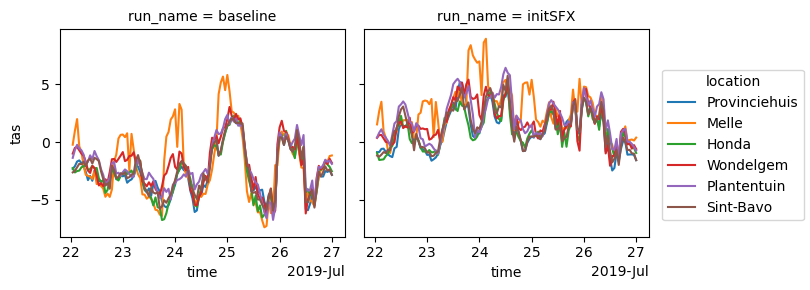

In [21]:
g = (ds_locations.tas - obs.tas).plot(x="time", hue="location", col="run_name")

In [22]:
(ds_locations.tas - obs.tas).mean(dim="time")

<xarray.DataArray 'tas' (location: 6, run_name: 2)>
array([[-2.71403936,  1.04013443],
       [-2.01451111,  2.72074661],
       [-2.70597651,  1.06752533],
       [-2.02824748,  1.78207764],
       [-2.07626973,  2.05037593],
       [-2.49320602,  1.26096776]])
Coordinates:
  * run_name  (run_name) <U8 'baseline' 'initSFX'
  * location  (location) <U13 'Provinciehuis' 'Melle' ... 'Sint-Bavo'
    crs       int64 0
    rstart    <U10 '2019070100'

The baseline simulation (with a cold start) has a significant cold bias between 2 and 3 degrees for all 6 MOCCA locations. The spun-up simulation has a warm bias between 1 and 2 degrees (with 2.7 degrees at one location). We can conclude that the simulation without spin-up performs best.

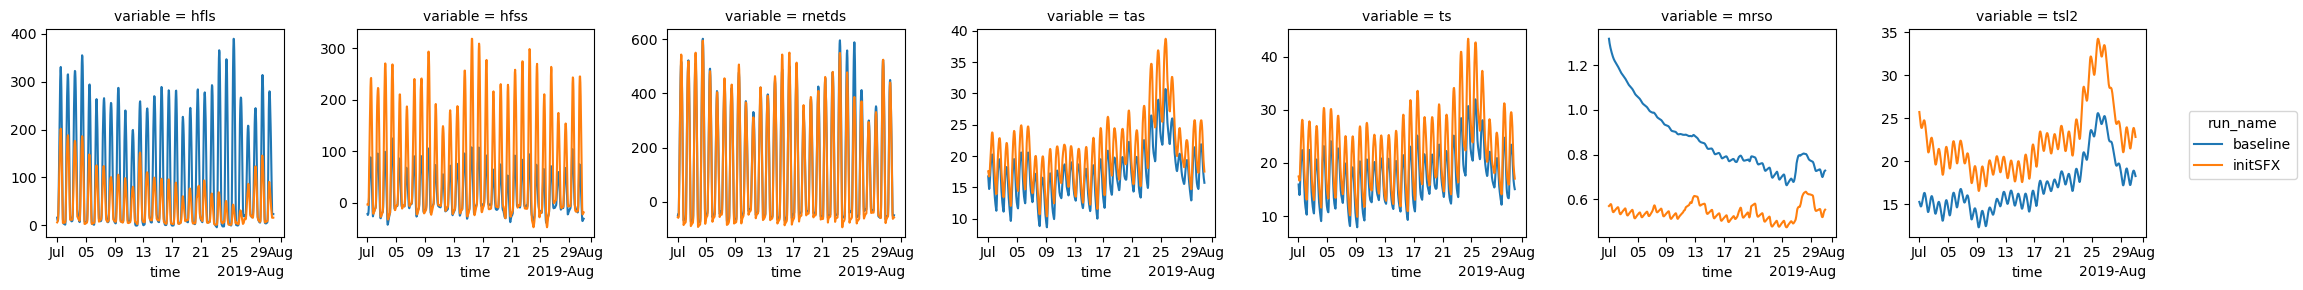

In [23]:
ds_vars = ds[var_name_list]
da_vars = ds_vars.to_dataarray()
da_vars_mean = da_vars.mean(dim=["lat", "lon"])
da_vars_mean.plot(x="time", col="variable", hue="run_name", sharey=False)

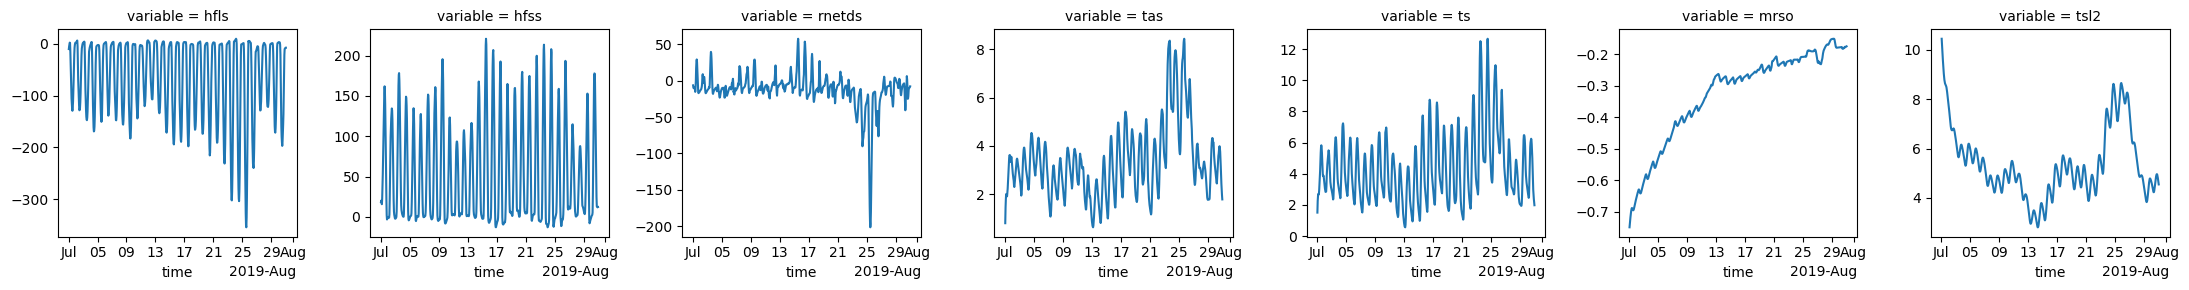

In [24]:
da_vars_mean.diff("run_name").plot(x="time", col="variable", sharey=False)

We can conclude a lot from these plots:
Firstly, from the soil moisture plot `mrso`, we can clearly see the effect of the spin-up on this variable. The simulation with a cold start first has to relax to a state with a drier soil, while the other simulation does not. This process is paired with a larger latent heat flux (because of the excess evaporation) in the cold start-simulation. This inhibits the surface from heating up in this simulation and cause the surface temperature to be colder. This, in turn, leads to a colder near-surface air temperature. The air temperature is higher in the simulation with spin-up period, because of the higher sensible heat flux. 

# 6. <a id='toc6_'></a>[Extra 1. Locations with a heatwave](#toc0_)

This extra exercise concerns the definition of a heat wave, as employed by the Belgian Royal Meteorological Institute. There, a heat wave period is defined as a period when the maximum temperatures in Uccle reach at least 25 degrees for at least 5 consecutive days, with at least 30 degrees being reached on at least three days. Write an algorithm to automatically detect heatwaves based on daily maximum temperatures. It is best to write it in two steps: 1) Select all periods which have at least five consecutive days above 25°C. 2) Check which of these periods contain at least three days with a temperature above 30°C. 

- Apply this algorithm on every point in the simulation dataset. What is the maximum number of heatwave days that you find over the domain?
- Apply this to the CLIMATE-GRID dataset. How long are the heat waves in this dataset?
- Compare observations and simulations. Create a basic contingency table classifying each day based on whether or not it is a heatwave day in the simulation or CLIMATE-GRID dataset. This creates four (2 x 2) classes for the heatwave days. Calculate some scores to assess the performance of the simulation. You can find some inspiration here: [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

## 6.1. <a id='toc6_1_'></a>[Solutions:](#toc0_)

In [25]:
tasmax = ds.tas.coarsen(time=24).max().sel(run_name="initSFX")
tasmax

<xarray.DataArray 'tas' (time: 30, lat: 70, lon: 75)>
array([[[25.344513 , 26.228485 , 26.43814  , ..., 26.685028 ,
         26.228271 , 25.911438 ],
        [25.327545 , 26.579681 , 26.267242 , ..., 26.57486  ,
         26.467194 , 26.08194  ],
        [25.145721 , 25.39862  , 25.296387 , ..., 26.598541 ,
         26.629486 , 26.144196 ],
        ...,
        [19.011017 , 18.744385 , 18.326813 , ..., 25.157135 ,
         25.05127  , 24.898499 ],
        [18.929688 , 18.476196 , 17.993011 , ..., 24.93164  ,
         24.849762 , 24.680176 ],
        [18.917053 , 18.592773 , 18.305603 , ..., 25.097015 ,
         25.10971  , 24.809204 ]],

       [[25.661865 , 26.288239 , 26.450531 , ..., 26.661896 ,
         26.13797  , 25.660461 ],
        [25.884705 , 26.703705 , 26.18988  , ..., 26.449005 ,
         26.208466 , 25.695862 ],
        [25.584503 , 25.837158 , 25.533722 , ..., 26.623474 ,
         26.312897 , 25.601593 ],
...
        [17.352875 , 17.28363  , 17.28888  , ..., 28.44345  ,
         28.165436 , 28.32669  ],
        [17.283539 , 17.244202 , 17.191223 , ..., 28.098969 ,
         27.94458  , 28.042175 ],
        [17.273651 , 17.172455 , 17.132965 , ..., 27.95758  ,
         28.212128 , 28.416473 ]],

       [[24.85791  , 25.386536 , 25.25064  , ..., 30.49591  ,
         30.424713 , 30.205353 ],
        [24.775818 , 25.44281  , 25.292236 , ..., 30.527893 ,
         30.454468 , 30.157837 ],
        [24.670593 , 24.933655 , 24.86905  , ..., 30.87912  ,
         30.629211 , 30.270233 ],
        ...,
        [17.623718 , 17.484985 , 17.434357 , ..., 32.848022 ,
         32.275574 , 32.063538 ],
        [17.582062 , 17.460419 , 17.404663 , ..., 32.539948 ,
         32.434814 , 32.065277 ],
        [17.556885 , 17.458588 , 17.365875 , ..., 32.92624  ,
         32.49704  , 31.671722 ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2019-07-01T12:30:00 ... 2019-07-30T12:30:00
  * lon       (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat       (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    crs       int64 0
    rstart    <U10 '2019070100'
    run_name  <U8 'initSFX'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          °C
    cell_methods:   time: point

In [26]:
def calc_heatwave_days_point(tasmax_point):
    # Initialize a boolean array
    heatwave_days_point = np.zeros_like(tasmax_point, dtype=bool)

    # Identify days above 25°C (potential heatwave days)
    heatwave_start = tasmax_point > 25

    # Find transitions to and from heatwave periods
    transitions = np.diff(heatwave_start.astype(int))

    # Get start and stop indices of heatwaves
    start_list = np.where(transitions == 1)[0] + 1
    stop_list = np.where(transitions == -1)[0]

    # Handle the edge case where a heatwave starts but doesn't end
    if heatwave_start[0]:
        start_list = np.insert(start_list, 0, 0)
    if heatwave_start[-1]:
        stop_list = np.append(stop_list, len(tasmax_point) - 1)

    # Validate the start/stop pair lengths
    assert len(start_list) == len(stop_list)

    # Filter heatwaves: periods where >3 days exceed 30°C
    for start, stop in zip(start_list, stop_list):
        tasmax_period = tasmax_point[start : stop + 1]
        days_above_30 = (tasmax_period > 30).sum()
        if days_above_30 >= 3:
            heatwave_days_point[start : stop + 1] = True

    return heatwave_days_point

In [27]:
def calc_heatwave_days(tasmax):
    # Apply the function using xarray's apply_ufunc
    heatwave_days = xr.apply_ufunc(
        calc_heatwave_days_point,  # Function to apply
        tasmax,  # Dataset
        input_core_dims=[["time"]],  # Apply along 'time'
        output_core_dims=[["time"]],
        vectorize=True,  # Vectorize over lat/lon
        output_dtypes=[bool],  # Output type
        dask="allowed",  # Enable Dask support if needed
    )

    return heatwave_days

In [28]:
heatwave_days = calc_heatwave_days(tasmax)

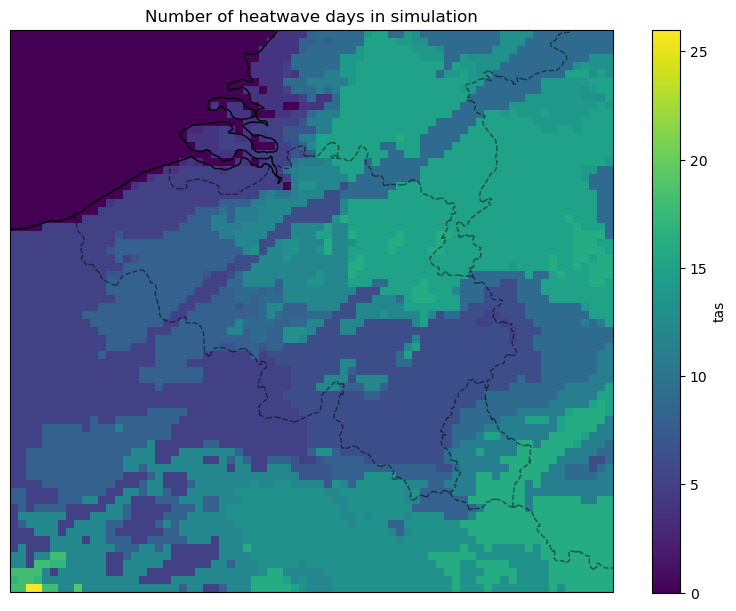

In [29]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(9, 6), layout="constrained"
)
heatwave_days.sum(dim="time").plot(x="lon", y="lat", ax=ax)
ax.set_aspect(14 / 9)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.5)
ax.set_title("Number of heatwave days in simulation");

In [30]:
heatwave_days_sum = heatwave_days.sum(dim="time")
heatwave_days_sum_max = heatwave_days_sum.max()
heatwave_days_sum_max_coords = heatwave_days_sum.where(heatwave_days_sum == heatwave_days_sum_max, drop=True).stack(z=("lat", "lon")).coords["z"]
heatwave_days_sum_max_coords

<xarray.DataArray 'z' (z: 2)>
array([(49.0, 2.14), (49.0, 2.21)], dtype=object)
Coordinates:
    crs       int64 0
    rstart    <U10 '2019070100'
    run_name  <U8 'initSFX'
  * z         (z) object MultiIndex
  * lat       (z) float64 49.0 49.0
  * lon       (z) float64 2.14 2.21

Let's select one of the points with the most heatwave days

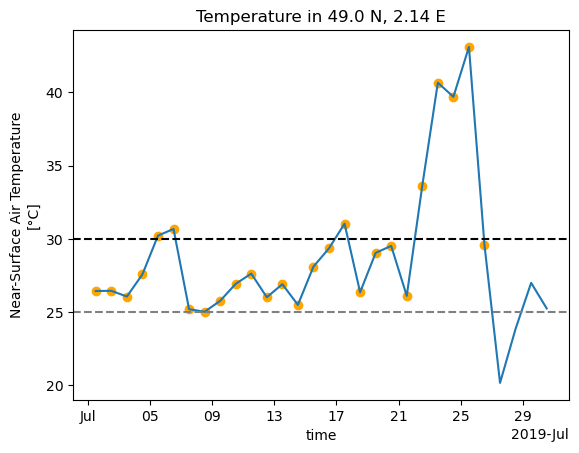

In [ ]:
lat = 49
lon = 2.14
heatwave_days_point = heatwave_days.sel(lat=lat, lon=lon)
tasmax_point = tasmax.sel(lon=lon, lat=lat)

fig, ax = plt.subplots()
tasmax_point.plot(ax=ax)
tasmax_point.where(heatwave_days_point).plot.scatter(ax=ax, color="orange")
ax.axhline(25, linestyle="--", color="grey")
ax.axhline(30, linestyle="--", color="k")
ax.set_title(f"Temperature in {lat:.1f} N, {lon:.2f} E");

# 7. <a id='toc7_'></a>[Extra 2. Simulation without urban areas](#toc0_)

The model which we have used for all simulations consists of an atmospheric part, ALARO, and a surface module, SURFEX. The interaction between the atmosphere and the surface is an important part of weather and climate modelling. These interactions depend heavily on the type of surface. SURFEX tackles this variety by considering four classes of surface: sea, (inland) water, town and nature. Based on an external dataset (ECOCLIMAP) every grid box of the model is assigned a certain fraction of each of these four classes. For example, for a model with a resolution of 4-km, we could find a grid box in a small town with 30 % town fraction and 70 % nature fraction. Also, a grid box containing a city by the coast could have a town fraction of 25 %, a nature fraction of 20 % and a sea fraction of 55 %. Note that the fractions for each grid box necessarily always sum to 100 %. Every part of the grid box is calculated separately by a sifferent sub-module, specific to the surface type. The output of these calculations (for example the near-surface air temperature) are then aggregated for the whole grid box, by taking a weighted average, with the land use fractions taken as weights. 

We will now investigate a simulation where we made some changes to the land use. For this simulation, we have taken every urban area and put it equal to rock. Normally, urban areas are calculated by the TEB (Town Energy Balance)-module, therefore we denote this simulation by `noTEB`. Explore this simulation by following the next steps:
- Load in the `tas` (near-surface air temperature) data for the simulations `initSFX` (with towns) and `initSFXnoTEB` (without towns) for the simulation starting on 1 July 2019 (720 hours). Select the period of the heat wave: 22 until 26 July 2019. 
- Load in the `land_use` data for both simulations. Plot all fractions for both simulations and verify the differences are as expected.
- Select only the data from points which have a town fraction higher than 20 % in the `initSFX`-simulations. Select these points for both simulations. In the `initSFXnoTEB`-simulation these points will have a 0 % town fraction.
- Calculate the average diurnal cycle of the temperature averaged over all points for both simulations. The average diurnal (or daily) cycle is calculated by taking the average of a variable for each hour of the day. The `groupby`-function from xarray will prove useful for this part.
- Compare the diurnal cycles for both simulations. What do you see? Plot the difference between both cycles. When is the difference largest?

## 7.1. <a id='toc7_1_'></a>[Solutions:](#toc0_)

In [4]:
var_name_list = ["tas"]
run_name_list = ["initSFX", "initSFXnoTEB"]
ds = open_data(data_dir, var_name_list, run_name_list)
ds

<xarray.Dataset>
Dimensions:      (time: 720, lon: 75, lat: 70, run_name: 2, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T01:00:00 ... 2019-07-31
  * lon          (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.97 7.04 7.11 7.18
  * lat          (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds    (time, bnds) datetime64[ns] 2019-07-01 ... 2019-07-31
    height       float64 2.0
    crs          int64 0
    rstart       <U10 '2019070100'
  * run_name     (run_name) <U12 'initSFX' 'initSFXnoTEB'
Dimensions without coordinates: bnds
Data variables:
    tas          (run_name, time, lat, lon) float32 16.69 17.13 ... 22.68 22.72
    frac_town    (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_water   (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_nature  (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
    frac_sea     (run_name, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-12T10:18:38Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

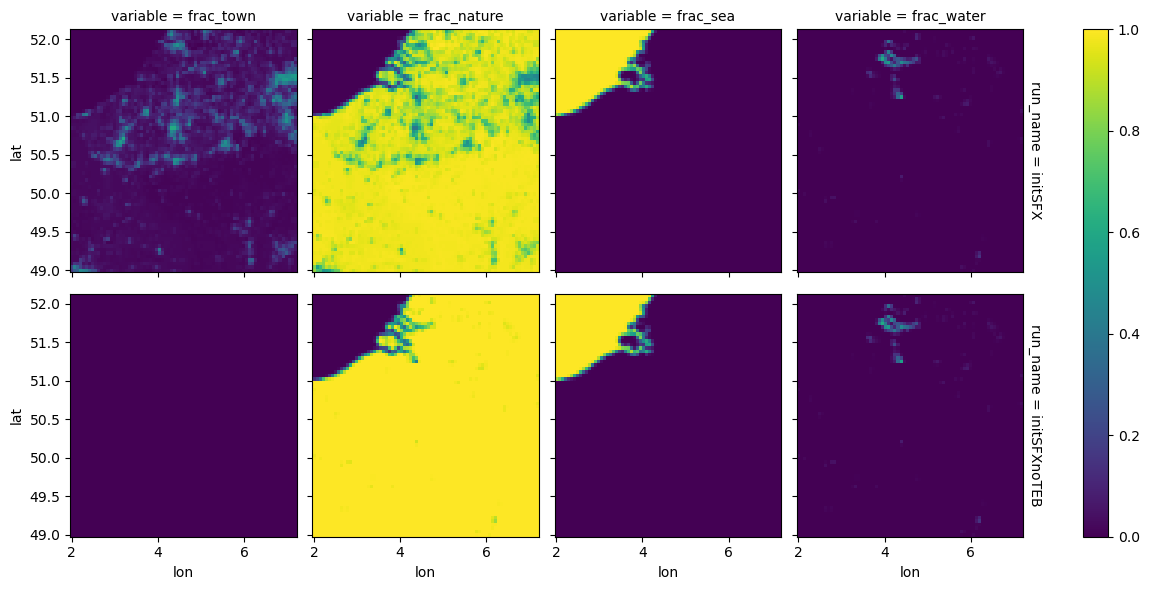

In [5]:
ds_land_use = ds[["frac_town", "frac_nature", "frac_sea", "frac_water"]]
ds_land_use.to_dataarray().plot(row="run_name", col="variable")
plt.show()

Only the town and nature fractions differ between both simulations. The town fraction is zero as expected in `initSFXnoTEB`.

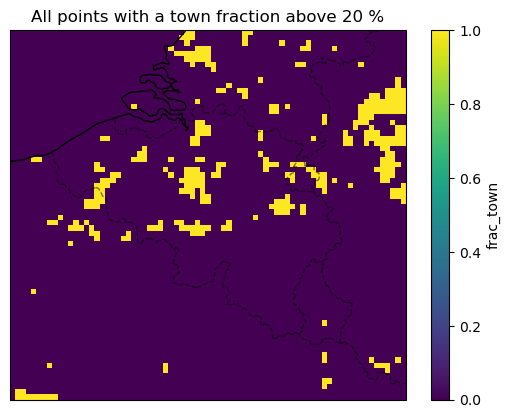

In [6]:
frac_town = ds_land_use.frac_town.sel(run_name="initSFX")
town_mask = frac_town > 0.2

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
town_mask.plot(ax=ax)
ax.set_title("All points with a town fraction above 20 %")
ax.set_aspect(14 / 9)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.5)

Text(0.5, 1.0, 'Diurnal cycle of difference in temperature\nin urban points')

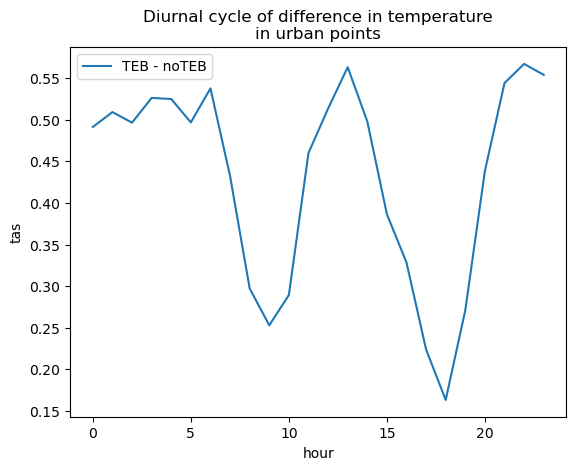

In [7]:
tstart = "2019-07-22T01"
tstop = "2019-07-27T00"

ds_period = ds.sel(time=slice(tstart, tstop))
tas_period = ds_period.tas
tas_period_town_mask = tas_period.where(town_mask)
tas_period_town_mask_diurnal_cycle = tas_period_town_mask.groupby("time.hour").mean()

tas_dc = tas_period_town_mask_diurnal_cycle.mean(dim=["lat", "lon"])
tas_nature_dc = tas_dc.sel(run_name="initSFXnoTEB")
tas_town_dc = tas_dc.sel(run_name="initSFX")

fig, ax = plt.subplots()
(tas_town_dc - tas_nature_dc).plot(ax=ax, x="hour", label="TEB - noTEB")
ax.legend()
ax.set_title("Diurnal cycle of difference in temperature\nin urban points")